In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
# #        print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [21]:
#importing necessary libraries
import numpy as np
import pandas as pd
import os
import librosa
import librosa.display
import IPython
from IPython.display import Audio
from IPython.display import Image
import matplotlib.pyplot as plt

In [22]:
EMOTIONS = {
    1: 'neutral', 
    2: 'calm', 
    3: 'happy', 
    4: 'sad', 
    5: 'angry', 
    6: 'fear', 
    7: 'disgust', 
    0: 'surprise'  # Note: 'surprise' is mapped to 0 instead of the original 8
}

DATA_PATH='/kaggle/input/ravdess-emotional-speech-audio'
SAMPLE_RATE=48000

In [25]:
# Initialize an empty list to store data before creating the DataFrame
data_list = []

# Walk through the directory and subdirectories in DATA_PATH
for dirname, _, filenames in os.walk(DATA_PATH):
    # Iterate through each file in the directory
    for filename in filenames:
        # Construct the full file path for each audio file
        file_path = os.path.join('/kaggle/input/', dirname, filename)
        
        # Extract identifiers from the filename, splitting by '.' and '-'
        identifiers = filename.split('.')[0].split('-')
        
        # Extract emotion from the filename (3rd identifier)
        emotion = int(identifiers[2])

        # Change the emotion value for 'surprise' from 8 to 0
        if emotion == 8:  # Adjusting 'surprise' emotion mapping from 8 to 0
            emotion = 0
        
        # Determine emotion intensity: '1' indicates normal, anything else is 'strong'
        if int(identifiers[3]) == 1:
            emotion_intensity = 'normal' 
        else:
            emotion_intensity = 'strong'
        
        # Identify gender: even actor IDs indicate 'female', odd IDs indicate 'male'
        if int(identifiers[6]) % 2 == 0:
            gender = 'female'
        else:
            gender = 'male'
        
        # Add the row as a dictionary to the list
        data_list.append({"Emotion": emotion,
                          "Emotion intensity": emotion_intensity,
                          "Gender": gender,
                          "Path": file_path})

# Convert the list of dictionaries into a DataFrame
data = pd.DataFrame(data_list)


In [26]:
print(f"number of data:{len(data)}")
data.head()

number of data:2880


,Emotion,Emotion intensity,Gender,Path
0,0,normal,female,/kaggle/input/ravdess-emotional-speech-audio/A...
1,1,normal,female,/kaggle/input/ravdess-emotional-speech-audio/A...
2,7,strong,female,/kaggle/input/ravdess-emotional-speech-audio/A...
3,7,normal,female,/kaggle/input/ravdess-emotional-speech-audio/A...
4,1,normal,female,/kaggle/input/ravdess-emotional-speech-audio/A...


In [27]:
mel_spectrograms = []
signals = [] 


for i, file_path in enumerate(data.Path):
    # Load the audio file with librosa; load 3 seconds of audio starting from 0.5 seconds
    audio, sample_rate = librosa.load(file_path, duration=3, offset=0.5, sr=SAMPLE_RATE)
    
    # Create an empty signal of length 3 seconds (SAMPLE_RATE * 3) filled with zeros
    signal = np.zeros((int(SAMPLE_RATE * 3,)))
    
    signal[:len(audio)] = audio
    
    signals.append(signal)
    
    print("\rProcessed {}/{} files".format(i + 1, len(data)), end='')

signals = np.stack(signals, axis=0)

Processed 2880/2880 files

In [28]:
X = signals  # Assign the processed signals to X for simplicity

train_ind, test_ind, val_ind = [], [], [] 
X_train, X_val, X_test = [], [], [] 
Y_train, Y_val, Y_test = [], [], []  

# Loop over each emotion category (based on the EMOTIONS dictionary)
for emotion in range(len(EMOTIONS)):
    # Get indices of all samples belonging to the current emotion
    emotion_ind = list(data.loc[data.Emotion == emotion, 'Emotion'].index)
    
    # Shuffle the indices randomly
    emotion_ind = np.random.permutation(emotion_ind)

    m = len(emotion_ind)
    ind_train = emotion_ind[:int(0.8 * m)]
    ind_val = emotion_ind[int(0.8 * m):int(0.9 * m)]
    ind_test = emotion_ind[int(0.9 * m):]

    X_train.append(X[ind_train, :])
    Y_train.append(np.array([emotion] * len(ind_train), dtype=np.int32)) 
    
    X_val.append(X[ind_val, :])
    Y_val.append(np.array([emotion] * len(ind_val), dtype=np.int32))
    
    X_test.append(X[ind_test, :])
    Y_test.append(np.array([emotion] * len(ind_test), dtype=np.int32))
    
    # Store the indices used for train, validation, and test sets
    train_ind.append(ind_train)
    test_ind.append(ind_test)
    val_ind.append(ind_val)

X_train = np.concatenate(X_train, 0)
X_val = np.concatenate(X_val, 0)
X_test = np.concatenate(X_test, 0)
Y_train = np.concatenate(Y_train, 0)
Y_val = np.concatenate(Y_val, 0)
Y_test = np.concatenate(Y_test, 0)

train_ind = np.concatenate(train_ind, 0)
val_ind = np.concatenate(val_ind, 0)
test_ind = np.concatenate(test_ind, 0)

# Print the shapes of the training, validation, and test sets for both data (X) and labels (Y)
print(f'X_train: {X_train.shape}, Y_train: {Y_train.shape}')
print(f'X_val: {X_val.shape}, Y_val: {Y_val.shape}')
print(f'X_test: {X_test.shape}, Y_test: {Y_test.shape}')

# Check if all indices are unique (i.e., there are no overlaps between train, validation, and test sets)
unique, count = np.unique(np.concatenate([train_ind, test_ind, val_ind], 0), return_counts=True)
print("Number of unique indexes is {}, out of {}".format(sum(count == 1), X.shape[0]))

# Delete the original signals array to free up memory
del X


X_train: (2302, 144000), Y_train: (2302,)
X_val: (285, 144000), Y_val: (285,)
X_test: (293, 144000), Y_test: (293,)
Number of unique indexes is 2880, out of 2880


In [29]:
def addAWGN(signal, num_bits=16, augmented_num=2, snr_low=15, snr_high=30): 
    
    signal_len = len(signal)  # Length of the input signal
    noise = np.random.normal(size=(augmented_num, signal_len))

    norm_constant = 2.0 ** (num_bits - 1)
    signal_norm = signal / norm_constant 
    noise_norm = noise / norm_constant    
    
    s_power = np.sum(signal_norm ** 2) / signal_len
    
    n_power = np.sum(noise_norm ** 2, axis=1) / signal_len
    
    target_snr = np.random.randint(snr_low, snr_high)
    
    K = np.sqrt((s_power / n_power) * 10 ** (- target_snr / 10))
    
    K = np.ones((signal_len, augmented_num)) * K
    
    return signal + K.T * noise



In [31]:
aug_signals = []  # List to store the augmented signals
aug_labels = []   # List to store the corresponding labels for the augmented signals

# Loop through each sample in the training set
for i in range(X_train.shape[0]):
    signal = X_train[i, :]  # Extract the i-th signal from X_train
    
    # Generate augmented signals by adding Additive White Gaussian Noise (AWGN) to the original signal
    augmented_signals = addAWGN(signal)
    
    # Loop through each of the generated augmented signals
    for j in range(augmented_signals.shape[0]):
        # Append the emotion label of the current sample to the augmented labels
        aug_labels.append(data.loc[i, "Emotion"])
        
        # Append the j-th augmented signal to the list of augmented signals
        aug_signals.append(augmented_signals[j, :])
        
        # Create a temporary DataFrame for the current data row
        temp_df = pd.DataFrame(data.iloc[i]).T
        
        # Concatenate the current row to the original DataFrame using pd.concat
        data = pd.concat([data, temp_df], ignore_index=True)
    
    # Print the progress of the augmentation process
    print("\rProcessed {}/{} files".format(i, X_train.shape[0]), end='')

# Convert the list of augmented signals into a NumPy array for easier concatenation
aug_signals = np.stack(aug_signals, axis=0)

# Concatenate the original training signals with the augmented signals
X_train = np.concatenate([X_train, aug_signals], axis=0)

# Convert the list of augmented labels into a NumPy array
aug_labels = np.stack(aug_labels, axis=0)

# Concatenate the original training labels with the augmented labels
Y_train = np.concatenate([Y_train, aug_labels])

# Print final shapes of the augmented training data and labels
print('')
print(f'X_train: {X_train.shape}, Y_train: {Y_train.shape}')


Processed 2301/2302 files
X_train: (6906, 144000), Y_train: (6906,)


MEL spectrogram shape:  (128, 563)


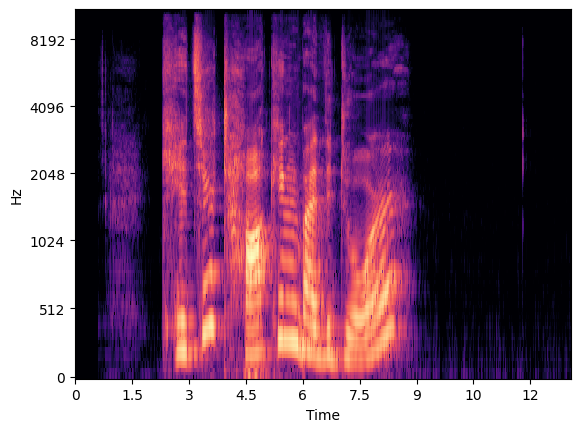

In [32]:
def getMELspectrogram(audio, sample_rate):
    mel_spec=librosa.feature.melspectrogram(y=audio,sr=sample_rate,n_fft=1024,win_length=512,window='hamming',hop_length=256,n_mels=128,fmax=sample_rate/2)
    # Convert power spectrogram to decibel scale
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db

audio, sample_rate = librosa.load(data.loc[0,'Path'], duration=3, offset=0.5, sr=SAMPLE_RATE)
# Create an empty signal array of length equal to 3 seconds
signal = np.zeros((int(SAMPLE_RATE*3,)))

# Fill the signal array with the audio data
signal[:len(audio)] = audio

mel_spectrogram = getMELspectrogram(signal, SAMPLE_RATE)

librosa.display.specshow(mel_spectrogram, y_axis='mel', x_axis='time')

print('MEL spectrogram shape: ',mel_spectrogram.shape)


In [33]:
# List to store the MEL spectrograms for the training set
mel_train = []
print("Calculating MEL spectrograms for train set")

# Loop through each sample in the training set
for i in range(X_train.shape[0]):
    # Compute the MEL spectrogram for the i-th training sample
    mel_spectrogram = getMELspectrogram(X_train[i, :], sample_rate=SAMPLE_RATE)
    
    # Append the computed MEL spectrogram to the list
    mel_train.append(mel_spectrogram)
    
    # Print progress of the MEL spectrogram calculation for training set
    print("\rProcessed {}/{} files".format(i, X_train.shape[0]), end='')

print('')  # New line after processing is complete
del X_train  # Free up memory by deleting the original X_train array

# List to store the MEL spectrograms for the validation set
mel_val = []
print("Calculating MEL spectrograms for validation set")

# Loop through each sample in the validation set
for i in range(X_val.shape[0]):
    # Compute the MEL spectrogram for the i-th validation sample
    mel_spectrogram = getMELspectrogram(X_val[i, :], sample_rate=SAMPLE_RATE)
    
    # Append the computed MEL spectrogram to the list
    mel_val.append(mel_spectrogram)
    
    # Print progress of the MEL spectrogram calculation for validation set
    print("\rProcessed {}/{} files".format(i, X_val.shape[0]), end='')

print('')  # New line after processing is complete
del X_val  # Free up memory by deleting the original X_val array

# List to store the MEL spectrograms for the test set
mel_test = []
print("Calculating MEL spectrograms for test set")

# Loop through each sample in the test set
for i in range(X_test.shape[0]):
    # Compute the MEL spectrogram for the i-th test sample
    mel_spectrogram = getMELspectrogram(X_test[i, :], sample_rate=SAMPLE_RATE)
    
    # Append the computed MEL spectrogram to the list
    mel_test.append(mel_spectrogram)
    
    # Print progress of the MEL spectrogram calculation for test set
    print("\rProcessed {}/{} files".format(i, X_test.shape[0]), end='')

print('')  # New line after processing is complete
del X_test  # Free up memory by deleting the original X_test array


Calculating MEL spectrograms for train set
Processed 6905/6906 files
Calculating MEL spectrograms for validation set
Processed 284/285 files
Calculating MEL spectrograms for test set
Processed 292/293 files


In [35]:
def splitIntoChunks(mel_spec, win_size, stride):
    t = mel_spec.shape[1]
    
    # Calculate the number of chunks based on the stride
    num_of_chunks = int(t / stride)

    chunks = []

    for i in range(num_of_chunks):
        chunk = mel_spec[:, i * stride:i * stride + win_size]
        
        # Only append the chunk if it has the correct size (win_size)
        if chunk.shape[1] == win_size:
            chunks.append(chunk)
    
    # Stack the list of chunks into a 3D numpy array (num_chunks, num_mels, win_size)
    return np.stack(chunks, axis=0)


In [36]:
# List to store chunked MEL spectrograms for the training set
mel_train_chunked = []

# Process each MEL spectrogram in the training set
for mel_spec in mel_train:
    chunks = splitIntoChunks(mel_spec, win_size=128, stride=64)
    mel_train_chunked.append(chunks)
print("Number of chunks is {}".format(chunks.shape[0]))
mel_val_chunked = []

# Process each MEL spectrogram in the validation set
for mel_spec in mel_val:
    chunks = splitIntoChunks(mel_spec, win_size=128, stride=64)
    mel_val_chunked.append(chunks)

print("Number of chunks is {}".format(chunks.shape[0]))

mel_test_chunked = []

# Process each MEL spectrogram in the test set
for mel_spec in mel_test:
    chunks = splitIntoChunks(mel_spec, win_size=128, stride=64)
    mel_test_chunked.append(chunks)
print("Number of chunks is {}".format(chunks.shape[0]))


Number of chunks is 7
Number of chunks is 7
Number of chunks is 7


In [37]:

#creating a model

import torch
import torch.nn as nn

# TimeDistributed layer for applying a module to each time step in a sequence
class TimeDistributed(nn.Module):
    def __init__(self, module):
        """
        Initialize the TimeDistributed layer.

        Parameters:
        - module: The PyTorch module to be applied at each time step.
        """
        super(TimeDistributed, self).__init__()
        self.module = module

    def forward(self, x):
        """
        Forward pass through the TimeDistributed layer.

        Parameters:
        - x: Input tensor with shape depending on the number of dimensions:
            - (samples, timesteps, inp1) for 3D tensor
            - (samples, timesteps, inp1, inp2) for 4D tensor
            - (samples, timesteps, inp1, inp2, inp3) for 5D tensor

        Returns:
        - y: Output tensor after applying the module, reshaped to match the input tensor's dimensions.
        """
        if len(x.size()) <= 2:
            return self.module(x)

        if len(x.size()) == 3:
            x_reshape = x.contiguous().view(-1, x.size(2)) 
        elif len(x.size()) == 4: 
            x_reshape = x.contiguous().view(-1, x.size(2), x.size(3))
        else: 
            x_reshape = x.contiguous().view(-1, x.size(2), x.size(3), x.size(4))
        
        # Apply the module to the reshaped tensor
        y = self.module(x_reshape)
        
        
        if len(x.size()) == 3:
            y = y.contiguous().view(x.size(0), -1, y.size(1)) 
        elif len(x.size()) == 4:
            y = y.contiguous().view(x.size(0), -1, y.size(1), y.size(2))  
        else:
            y = y.contiguous().view(x.size(0), -1, y.size(1), y.size(2), y.size(3))  
        return y

